In [1]:
#Question 1

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from pyDOE import *

def train_model2(Nf):
    
    def xavier_init(size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def initialize_NN(layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def neural_net(X, weights, biases):
        num_layers = len(weights) + 1
        H = X
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def net_u(x, weights, biases):
        u = neural_net(x, weights, biases)
        return u
    
    def net_f(x, weights, biases):
        u = net_u(x, weights, biases)
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        f = u_xx - u + (np.pi**2 + 1) * tf.sin(np.pi * x)
        return f
    
    x_data1 = lhs(1, samples=Nf)
    x_data1 = (x_data1 - 0.5)*2.
    x_data2 = np.zeros((2,1))
    x_data2[0] = -1.0
    x_data2[1] = 1.0
    layers = [1, 50, 50, 1]
    
    weights, biases = initialize_NN(layers)
    xs_u = tf.placeholder(tf.float32,[None,1])
    xs_f = tf.placeholder(tf.float32,[None,1])

    y_u = net_u(xs_u, weights, biases)
    y_f = net_f(xs_f, weights, biases)

    loss_u = tf.reduce_mean(tf.square(y_u))
    loss_f = tf.reduce_mean(tf.square(y_f))
    loss = loss_u + loss_f
    train_step =  tf.train.AdamOptimizer(0.001).minimize(loss)

            
    epochs = 5000

    #train section
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(epochs):
            sess.run(train_step, feed_dict={xs_f: x_data1, xs_u: x_data2})
            if i % 1000 == 0:
                loss_uu, loss_ff = sess.run([loss_u, loss_f], feed_dict={xs_f: x_data1, xs_u: x_data2})
        x_test = np.linspace(-1, 1, 100)[:,None]
        prediction_value = sess.run(y_u, feed_dict={xs_u: x_test})

    y_test = np.sin(np.pi * x_test)
    return x_test, y_test, prediction_value


/home/tkar/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tkar/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tkar/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tkar/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWa

In [2]:
x_test, y_test, prediction_value = train_model2(Nf = 100)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


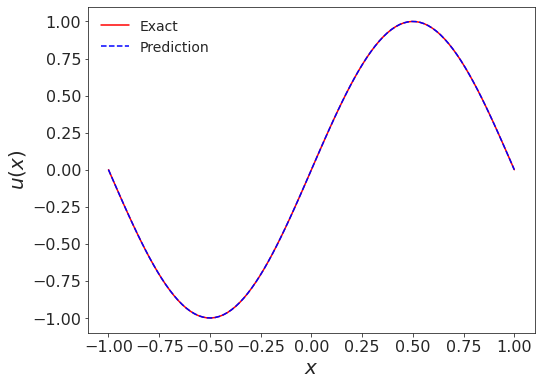

In [6]:
plt.figure(3, figsize=(8, 6), facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 14})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(x_test, y_test, 'r-', label = 'Exact')
plt.plot(x_test, prediction_value, 'b--', label = 'Prediction')
plt.xlabel('$x$',fontsize=20)
plt.ylabel('$u(x)$',fontsize=20)
plt.legend(loc='upper left', frameon=False, prop={'size': 14})


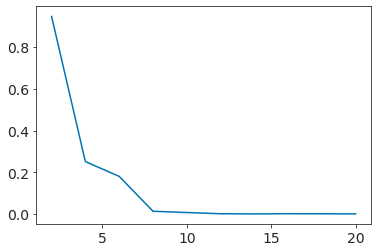

In [7]:
N = np.linspace(2, 20, 10, dtype = np.int32)
Loss = np.zeros_like(N) * 1.0
for i in range(N.shape[0]):
    x_test, y_test, prediction_value = train_model2(N[i])
    Loss[i] = np.linalg.norm(prediction_value - y_test, 2)/ np.linalg.norm(y_test, 2)
    
fig = plt.figure(2)
plt.plot(N, Loss)
plt.show()

In [9]:
#Question 2

import torch
import numpy as np
import torch.utils.data
import torch.nn.functional as F
from torch.autograd import Variable
import timeit

class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 6, kernel_size=5, padding=2),
            torch.nn.BatchNorm2d(6),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(6, 12, kernel_size=5, padding=2),
            torch.nn.BatchNorm2d(12),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(12, 24, kernel_size=5, padding=2),
            torch.nn.BatchNorm2d(24),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(4 * 4 * 24, 120),
            torch.nn.Tanh())
        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(120, 84),
            torch.nn.Tanh())
        self.fc3 = torch.nn.Sequential(
            torch.nn.Linear(84, 10))

    def forward_pass(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


class ConvNet:
    # Initialize the class
    def __init__(self, X, Y):  
        
        # Check if there is a GPU available
        if torch.cuda.is_available() == True:
            self.dtype_double = torch.cuda.FloatTensor
            self.dtype_int = torch.cuda.LongTensor
        else:
            self.dtype_double = torch.FloatTensor
            self.dtype_int = torch.LongTensor
        
        # Define PyTorch dataset
        X = torch.from_numpy(X).type(self.dtype_double) # num_images x num_pixels_x x num_pixels_y
        Y = torch.from_numpy(Y).type(self.dtype_int) # num_images x 1
        self.train_data = torch.utils.data.TensorDataset(X, Y)
        
        # Define architecture and initialize
        self.net = CNN()
        
        # Define the loss function
        self.loss_fn = torch.nn.CrossEntropyLoss()
        
        # Define the optimizer
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-3)
        
           
    # Trains the model by minimizing the Cross Entropy loss
    def train(self, num_epochs = 10, batch_size = 128):
        
        # Create a PyTorch data loader object
        self.trainloader = torch.utils.data.DataLoader(self.train_data, 
                                                  batch_size=batch_size, 
                                                  shuffle=True)
       
        start_time = timeit.default_timer()
        for epoch in range(num_epochs):
            for it, (images, labels) in enumerate(self.trainloader):
                images = Variable(images)
                labels = Variable(labels)
        
                # Reset gradients
                self.optimizer.zero_grad()
                
                # Forward pass
                outputs = self.net.forward_pass(images)
                
                # Compute loss
                loss = self.loss_fn(outputs, labels)
                
                # Backward pass
                loss.backward()
                
                # Update parameters
                self.optimizer.step()
        
                if (it+1) % 100 == 0:
                    elapsed = timeit.default_timer() - start_time
                    print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, Time: %2fs' 
                           %(epoch+1, num_epochs, it+1, len(self.train_data)//batch_size, loss.cpu().data, elapsed))
                    start_time = timeit.default_timer()
                   
                    
    def test(self, X, Y):
        # Define PyTorch dataset
        X = torch.from_numpy(X).type(self.dtype_double) # num_images x num_pixels_x x num_pixels_y
        Y = torch.from_numpy(Y).type(self.dtype_int) # num_images x 1
        test_data = torch.utils.data.TensorDataset(X, Y)
       
        # Create a PyTorch data loader object
        test_loader = torch.utils.data.DataLoader(test_data, 
                                                  batch_size=128, 
                                                  shuffle=True)
        
        # Test prediction accuracy
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = Variable(images)
            outputs = self.net.forward_pass(images)
            _, predicted = torch.max(outputs.cpu().data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()

        print('Test Accuracy of the model on the %d test images: %.5f %%' % (len(test_data), 100.0 * correct / total))
        
    
    # Evaluates predictions at test points    
    def predict(self, X_star):
        X_star = torch.from_numpy(X_star).type(self.dtype_double) 
        X_star = Variable(X_star, requires_grad=False)
        y_star = self.net.forward_pass(X_star)
        y_star = y_star.cpu().data.numpy()
        return y_star

In [ ]:
#Ignore the dataset opening and follow the following code template/setup to train and test your CNN on the cell images dataset

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pickle

f1 = open('./cifar10batchespy/data_batch_1','rb')
dic1 = pickle.load(f1,encoding='bytes')    
f2 = open('./cifar10batchespy/data_batch_2','rb')
dic2 = pickle.load(f2,encoding='bytes') 
f3 = open('./cifar10batchespy/data_batch_3','rb')
dic3 = pickle.load(f3,encoding='bytes')  
f4 = open('./cifar10batchespy/data_batch_4','rb')
dic4 = pickle.load(f4,encoding='bytes')  
f5 = open('./cifar10batchespy/data_batch_5','rb')
dic5 = pickle.load(f5,encoding='bytes')

f6 = open('./cifar10batchespy/test_batch','rb')
dic6 = pickle.load(f6,encoding='bytes')

data_train = np.vstack((dic1[b'data'],dic2[b'data'],dic3[b'data'],dic4[b'data'],dic5[b'data']))
labels_train = np.concatenate((dic1[b'labels'],dic2[b'labels'],dic3[b'labels'],dic4[b'labels'],dic5[b'labels']))
data_test = dic6[b'data']
labels_test = dic6[b'labels']
print(np.shape(data_train))
print(np.shape(labels_train))
print(np.shape(data_test))
print(np.shape(labels_test))

    
mean = np.mean(data_train, axis = 0)
std = np.std(data_train, axis = 0)

data_train = (data_train - mean)/std
data_test = (data_test - mean)/std

data_train = np.reshape(data_train, (-1, 3, 32, 32))
data_test = np.reshape(data_test, (-1, 3, 32, 32))

train_images = data_train
test_images = data_test

train_labels = np.asarray(label_train)
test_labels = np.asarray(labels_test)

label = []
for i in range(len(train_labels)):
    for j in range(10):
        if train_labels[i, j] == 1.:
            label.append(j)     
            
train_labels = np.asarray(label)


In [3]:
import numpy as np
import pickle, gzip
import matplotlib.pyplot as plt

if __name__ == "__main__": 
    
    # Define model
    model = ConvNet(train_images, train_labels)
        
    # Train
    model.train(num_epochs = 20, batch_size = 128)
    
    # Evaluate test performance
    model.test(test_images, test_labels)
    
    # Predict
    predicted_labels = np.argmax(model.predict(test_images),1)
    
    # Plot a random prediction
    idx = np.random.permutation(predicted_labels.shape[0])[0]
    #print('Correct label: %d, Predicted label: %d' % (test_labels[idx], predicted_labels[idx]))

NameError: name 'ConvNet' is not defined

In [8]:
#Question 3

import scipy
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

import torch
import numpy as np
import torch.utils.data
import torch.nn.functional as F
import timeit

from torch.autograd import Variable

class LSTM:
    # Initialize the class
    def __init__(self, X, Y, hidden_dim):
        
        # Check if there is a GPU available
        if torch.cuda.is_available() == True:
            self.dtype = torch.cuda.FloatTensor
        else:
            self.dtype = torch.FloatTensor
            
        # X has the form lags x data x dim
        # Y has the form data x dim

        # Define PyTorch variables
        X = torch.from_numpy(X).type(self.dtype)
        Y = torch.from_numpy(Y).type(self.dtype)
        self.X = Variable(X, requires_grad=False)
        self.Y = Variable(Y, requires_grad=False)
                 
        self.X_dim = X.shape[-1]
        self.Y_dim = Y.shape[-1]
        self.hidden_dim = hidden_dim
        self.lags = X.shape[0]
        
        # Initialize network weights and biases        
        self.U_o, self.b_o, self.W_o, self.U_s, self.b_s, self.W_s, self.U_i, self.b_i, self.W_i, self.U_f, self.b_f, self.W_f, self.V, self.c = self.initialize_LSTM()
                
        #Sigmoid and Tanh Acitvation functions
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
        
        # Store loss values
        self.training_loss = []
      
        # Define optimizer
        self.optimizer = torch.optim.Adam([self.U_o, self.b_o, self.W_o, self.U_s, self.b_s, self.W_s, self.U_i, self.b_i, self.W_i, self.U_f, self.b_f, self.W_f, self.V, self.c], lr=1e-3)
    
    # Initialize network weights and biases using Xavier initialization
    def initialize_LSTM(self):      
        # Xavier initialization
        def xavier_init(size):
            in_dim = size[0]
            out_dim = size[1]
            xavier_stddev = np.sqrt(2.0/(in_dim + out_dim))
            return Variable(xavier_stddev*torch.randn(in_dim, out_dim).type(self.dtype), requires_grad=True)
        
        U_o = xavier_init(size=[self.X_dim, self.hidden_dim])
        b_o = Variable(torch.zeros(1,self.hidden_dim).type(self.dtype), requires_grad=True)
        W_o = Variable(torch.eye(self.hidden_dim).type(self.dtype), requires_grad=True)
        
        U_s = xavier_init(size=[self.X_dim, self.hidden_dim])
        b_s = Variable(torch.zeros(1,self.hidden_dim).type(self.dtype), requires_grad=True)
        W_s = Variable(torch.eye(self.hidden_dim).type(self.dtype), requires_grad=True)
        
        U_i = xavier_init(size=[self.X_dim, self.hidden_dim])
        b_i = Variable(torch.zeros(1,self.hidden_dim).type(self.dtype), requires_grad=True)
        W_i = Variable(torch.eye(self.hidden_dim).type(self.dtype), requires_grad=True)
        
        U_f = xavier_init(size=[self.X_dim, self.hidden_dim])
        b_f = Variable(torch.zeros(1,self.hidden_dim).type(self.dtype), requires_grad=True)
        W_f = Variable(torch.eye(self.hidden_dim).type(self.dtype), requires_grad=True)
        
        V = xavier_init(size=[self.hidden_dim, self.Y_dim])
        c = Variable(torch.zeros(1,self.Y_dim).type(self.dtype), requires_grad=True)
        
        return U_o, b_o, W_o, U_s, b_s, W_s, U_i, b_i, W_i, U_f, b_f, W_f, V, c
    
    #Maybe use torch.mul(a, b) for element wise matrix multiplication if it doesn't work out?
    def forward_pass(self, X):
        H = torch.zeros(X.shape[1], self.hidden_dim).type(self.dtype)
        s_t = torch.zeros(X.shape[1], self.hidden_dim).type(self.dtype)
        
        for i in range(0, self.lags):
            f_t = self.sigmoid(torch.matmul(H, self.W_f) + torch.matmul(X[i,:,:], self.U_f) + self.b_f)
            i_t = self.sigmoid(torch.matmul(H, self.W_i) + torch.matmul(X[i,:,:], self.U_i) + self.b_i)
            s_t_tilda = self.tanh(torch.matmul(H, self.W_s) + torch.matmul(X[i,:,:], self.U_s) + self.b_s)
            s_t = f_t * s_t + i_t * s_t_tilda
            O_t = self.sigmoid(torch.matmul(H, self.W_o) + torch.matmul(X[i,:,:], self.U_o) + self.b_o)
            H = O_t * self.tanh(s_t)  
            
        H = torch.matmul(H, self.V) + self.c
        return H
    
    # Computes the mean square error loss
    def compute_loss(self, X, Y):
        loss = torch.mean((Y - self.forward_pass(X))**2)
        return loss
        
    # Fetches a mini-batch of data
    def fetch_minibatch(self,X, y, N_batch):
        N = X.shape[1]
        idx = torch.randperm(N)[0:N_batch]
        X_batch = X[:,idx,:]
        y_batch = y[idx,:]        
        return X_batch, y_batch
    
    # Trains the model by minimizing the MSE loss
    def train(self, nIter = 10000, batch_size = 100):
        
        start_time = timeit.default_timer()
        for it in range(nIter):
            # Fetch mini-batch
            X_batch, Y_batch = self.fetch_minibatch(self.X, self.Y, batch_size)
            
            loss = self.compute_loss(X_batch, Y_batch)
            print(it, loss.data)
            
            # Store loss value
            self.training_loss.append(loss)
            
            # Backward pass
            loss.backward()
            
            # update parameters
            self.optimizer.step()
            
            # Reset gradients for next step
            self.optimizer.zero_grad()
            
            # Print
            if it % 50 == 0:
                elapsed = timeit.default_timer() - start_time
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss.cpu().data.numpy(), elapsed))
                start_time = timeit.default_timer()
    
    
   # Evaluates predictions at test points    
    def predict(self, X_star):
        X_star = torch.from_numpy(X_star).type(self.dtype)
        y_star = self.forward_pass(X_star)
        y_star = y_star.cpu().data.numpy()
        return y_star

In [9]:
alpha = 1
beta = .1
gamma = 1.5
sigma = .75

def lotka_volterra(X, t):
    dxdt = X[0] * (alpha - beta * X[1])
    dydt = -X[1] * (gamma - sigma * X[0])
    return np.array([dxdt, dydt])

x_0 = 10
y_0 = 5
init = np.array([x_0, y_0])
t = np.linspace(0, 60, 2000)

def create_dataset(data, lags):
    N = len(data) - lags
    data_dim = data.shape[1]
    X = np.zeros((lags, N, data_dim))
    Y = np.zeros((N, data_dim))
    
    for i in range(0, N):
        X[:,i,:] = data[i:(i + lags), :]
        Y[i,:] = data[i + lags, :]
        
    return X, Y

sol = odeint(lotka_volterra, init, t)
dataset = (sol - np.mean(sol, axis=0, keepdims=True))/ np.std(sol, axis=0, keepdims=True)

# Use 2/3 of all data as training Data
train_size = int(len(dataset) * (2.0 / 3.0))
train = dataset[0:train_size, :]

# reshape X and Y
# X has the form lags x data x dim
# Y has the form data x dim
lags = 8
X, Y = create_dataset(train, lags)

#Testing data set
test = dataset[train_size:, :]

# Model creation, hidden layer dimension is 20 as specified in the problem statement
hidden_dim = 20
model = LSTM(X, Y, hidden_dim)

In [10]:
#Train the model
model.train(nIter = 10000, batch_size = 128)



0 tensor(1.0649)
It: 0, Loss: 1.065e+00, Time: 0.01
1 tensor(0.9169)
2 tensor(0.9497)
3 tensor(1.2895)
4 tensor(0.9939)
5 tensor(0.8872)
6 tensor(0.8957)
7 tensor(1.0948)
8 tensor(0.8594)
9 tensor(0.8406)
10 tensor(0.7503)
11 tensor(1.0021)
12 tensor(0.6539)
13 tensor(1.0351)
14 tensor(0.7654)
15 tensor(0.7442)
16 tensor(0.5097)
17 tensor(0.8311)
18 tensor(0.8024)
19 tensor(0.5814)
20 tensor(0.8606)
21 tensor(0.7244)
22 tensor(0.7176)
23 tensor(0.7344)
24 tensor(0.7268)
25 tensor(0.6754)
26 tensor(0.6565)
27 tensor(0.5499)
28 tensor(0.6249)
29 tensor(0.5979)
30 tensor(0.5169)
31 tensor(0.4792)
32 tensor(0.4305)
33 tensor(0.5600)
34 tensor(0.3880)
35 tensor(0.4119)
36 tensor(0.5099)
37 tensor(0.4545)
38 tensor(0.3119)
39 tensor(0.4378)
40 tensor(0.3769)
41 tensor(0.4812)
42 tensor(0.5077)
43 tensor(0.4533)
44 tensor(0.2932)
45 tensor(0.4723)
46 tensor(0.3524)
47 tensor(0.5622)
48 tensor(0.4645)
49 tensor(0.3358)
50 tensor(0.3008)
It: 50, Loss: 3.008e-01, Time: 0.26
51 tensor(0.3334)
52 

453 tensor(0.0013)
454 tensor(0.0021)
455 tensor(0.0011)
456 tensor(0.0017)
457 tensor(0.0016)
458 tensor(0.0012)
459 tensor(0.0013)
460 tensor(0.0009)
461 tensor(0.0019)
462 tensor(0.0012)
463 tensor(0.0018)
464 tensor(0.0013)
465 tensor(0.0018)
466 tensor(0.0008)
467 tensor(0.0013)
468 tensor(0.0017)
469 tensor(0.0010)
470 tensor(0.0014)
471 tensor(0.0012)
472 tensor(0.0014)
473 tensor(0.0015)
474 tensor(0.0022)
475 tensor(0.0012)
476 tensor(0.0014)
477 tensor(0.0007)
478 tensor(0.0014)
479 tensor(0.0016)
480 tensor(0.0016)
481 tensor(0.0020)
482 tensor(0.0013)
483 tensor(0.0015)
484 tensor(0.0017)
485 tensor(0.0010)
486 tensor(0.0012)
487 tensor(0.0025)
488 tensor(0.0020)
489 tensor(0.0012)
490 tensor(0.0019)
491 tensor(0.0010)
492 tensor(0.0024)
493 tensor(0.0007)
494 tensor(0.0013)
495 tensor(0.0019)
496 tensor(0.0016)
497 tensor(0.0010)
498 tensor(0.0007)
499 tensor(0.0018)
500 tensor(0.0016)
It: 500, Loss: 1.628e-03, Time: 0.24
501 tensor(0.0014)
502 tensor(0.0011)
503 tensor(0.

886 tensor(0.0007)
887 tensor(0.0007)
888 tensor(0.0006)
889 tensor(0.0005)
890 tensor(0.0008)
891 tensor(0.0005)
892 tensor(0.0004)
893 tensor(0.0012)
894 tensor(0.0005)
895 tensor(0.0007)
896 tensor(0.0006)
897 tensor(0.0005)
898 tensor(0.0006)
899 tensor(0.0006)
900 tensor(0.0004)
It: 900, Loss: 3.621e-04, Time: 0.23
901 tensor(0.0002)
902 tensor(0.0007)
903 tensor(0.0003)
904 tensor(0.0007)
905 tensor(0.0002)
906 tensor(0.0006)
907 tensor(0.0007)
908 tensor(0.0003)
909 tensor(0.0005)
910 tensor(0.0005)
911 tensor(0.0002)
912 tensor(0.0006)
913 tensor(0.0009)
914 tensor(0.0007)
915 tensor(0.0006)
916 tensor(0.0007)
917 tensor(0.0006)
918 tensor(0.0006)
919 tensor(0.0003)
920 tensor(0.0007)
921 tensor(0.0005)
922 tensor(0.0005)
923 tensor(0.0003)
924 tensor(0.0006)
925 tensor(0.0002)
926 tensor(0.0004)
927 tensor(0.0005)
928 tensor(0.0006)
929 tensor(0.0007)
930 tensor(0.0005)
931 tensor(0.0003)
932 tensor(0.0004)
933 tensor(0.0007)
934 tensor(0.0002)
935 tensor(0.0005)
936 tensor(0.

1322 tensor(0.0001)
1323 tensor(0.0003)
1324 tensor(0.0002)
1325 tensor(0.0001)
1326 tensor(0.0003)
1327 tensor(0.0003)
1328 tensor(0.0003)
1329 tensor(0.0002)
1330 tensor(0.0001)
1331 tensor(0.0001)
1332 tensor(8.4458e-05)
1333 tensor(0.0001)
1334 tensor(0.0004)
1335 tensor(9.7570e-05)
1336 tensor(0.0001)
1337 tensor(0.0002)
1338 tensor(0.0002)
1339 tensor(0.0001)
1340 tensor(0.0002)
1341 tensor(0.0002)
1342 tensor(0.0002)
1343 tensor(0.0002)
1344 tensor(0.0002)
1345 tensor(0.0002)
1346 tensor(0.0002)
1347 tensor(0.0002)
1348 tensor(0.0002)
1349 tensor(0.0001)
1350 tensor(0.0002)
It: 1350, Loss: 1.807e-04, Time: 0.23
1351 tensor(0.0002)
1352 tensor(0.0002)
1353 tensor(0.0003)
1354 tensor(0.0002)
1355 tensor(0.0001)
1356 tensor(0.0001)
1357 tensor(0.0002)
1358 tensor(8.8210e-05)
1359 tensor(0.0002)
1360 tensor(8.9367e-05)
1361 tensor(6.3650e-05)
1362 tensor(8.1609e-05)
1363 tensor(0.0002)
1364 tensor(0.0002)
1365 tensor(0.0001)
1366 tensor(0.0002)
1367 tensor(0.0002)
1368 tensor(0.0001

1714 tensor(8.6029e-05)
1715 tensor(0.0001)
1716 tensor(0.0001)
1717 tensor(0.0001)
1718 tensor(0.0001)
1719 tensor(5.8466e-05)
1720 tensor(5.3863e-05)
1721 tensor(9.4873e-05)
1722 tensor(0.0001)
1723 tensor(5.7124e-05)
1724 tensor(8.1295e-05)
1725 tensor(7.0155e-05)
1726 tensor(0.0001)
1727 tensor(6.8598e-05)
1728 tensor(7.5698e-05)
1729 tensor(0.0001)
1730 tensor(0.0001)
1731 tensor(6.1150e-05)
1732 tensor(7.9910e-05)
1733 tensor(8.4409e-05)
1734 tensor(6.6175e-05)
1735 tensor(8.0533e-05)
1736 tensor(8.8225e-05)
1737 tensor(5.3709e-05)
1738 tensor(0.0001)
1739 tensor(9.8314e-05)
1740 tensor(9.1137e-05)
1741 tensor(9.4399e-05)
1742 tensor(0.0001)
1743 tensor(5.8710e-05)
1744 tensor(0.0001)
1745 tensor(5.8420e-05)
1746 tensor(9.5619e-05)
1747 tensor(0.0001)
1748 tensor(6.5047e-05)
1749 tensor(7.8819e-05)
1750 tensor(7.1347e-05)
It: 1750, Loss: 7.135e-05, Time: 0.24
1751 tensor(4.2925e-05)
1752 tensor(7.8955e-05)
1753 tensor(6.8094e-05)
1754 tensor(5.5680e-05)
1755 tensor(7.5235e-05)
17

2081 tensor(5.4374e-05)
2082 tensor(3.8701e-05)
2083 tensor(4.5090e-05)
2084 tensor(5.3112e-05)
2085 tensor(3.7316e-05)
2086 tensor(4.5799e-05)
2087 tensor(4.7406e-05)
2088 tensor(2.5090e-05)
2089 tensor(4.2666e-05)
2090 tensor(4.9977e-05)
2091 tensor(4.9507e-05)
2092 tensor(4.5172e-05)
2093 tensor(4.3166e-05)
2094 tensor(3.6326e-05)
2095 tensor(1.9114e-05)
2096 tensor(4.7715e-05)
2097 tensor(3.0094e-05)
2098 tensor(3.6052e-05)
2099 tensor(5.0612e-05)
2100 tensor(4.9716e-05)
It: 2100, Loss: 4.972e-05, Time: 0.24
2101 tensor(5.3781e-05)
2102 tensor(5.9969e-05)
2103 tensor(3.6727e-05)
2104 tensor(2.5017e-05)
2105 tensor(3.5786e-05)
2106 tensor(3.9610e-05)
2107 tensor(4.7556e-05)
2108 tensor(3.1903e-05)
2109 tensor(3.6697e-05)
2110 tensor(2.8613e-05)
2111 tensor(5.2738e-05)
2112 tensor(5.0142e-05)
2113 tensor(2.7378e-05)
2114 tensor(3.5762e-05)
2115 tensor(4.4641e-05)
2116 tensor(3.9533e-05)
2117 tensor(3.4210e-05)
2118 tensor(1.5036e-05)
2119 tensor(4.0396e-05)
2120 tensor(5.1491e-05)
21

2413 tensor(3.3035e-05)
2414 tensor(2.3170e-05)
2415 tensor(2.2150e-05)
2416 tensor(2.4356e-05)
2417 tensor(3.7103e-05)
2418 tensor(2.1453e-05)
2419 tensor(2.1742e-05)
2420 tensor(3.6390e-05)
2421 tensor(3.3622e-05)
2422 tensor(2.9944e-05)
2423 tensor(3.1397e-05)
2424 tensor(1.7948e-05)
2425 tensor(2.0925e-05)
2426 tensor(2.3608e-05)
2427 tensor(2.3267e-05)
2428 tensor(1.9612e-05)
2429 tensor(2.5667e-05)
2430 tensor(2.7823e-05)
2431 tensor(3.1990e-05)
2432 tensor(3.1873e-05)
2433 tensor(2.4179e-05)
2434 tensor(1.6939e-05)
2435 tensor(2.5592e-05)
2436 tensor(3.2952e-05)
2437 tensor(2.3282e-05)
2438 tensor(2.1138e-05)
2439 tensor(3.8485e-05)
2440 tensor(2.6466e-05)
2441 tensor(2.6301e-05)
2442 tensor(2.7599e-05)
2443 tensor(2.7433e-05)
2444 tensor(2.0408e-05)
2445 tensor(2.3830e-05)
2446 tensor(3.6536e-05)
2447 tensor(1.8643e-05)
2448 tensor(2.4319e-05)
2449 tensor(2.8799e-05)
2450 tensor(1.6441e-05)
It: 2450, Loss: 1.644e-05, Time: 0.28
2451 tensor(1.8508e-05)
2452 tensor(2.0796e-05)
24

2786 tensor(2.1613e-05)
2787 tensor(1.4756e-05)
2788 tensor(1.9225e-05)
2789 tensor(1.6337e-05)
2790 tensor(1.8133e-05)
2791 tensor(2.0505e-05)
2792 tensor(1.8143e-05)
2793 tensor(1.7863e-05)
2794 tensor(1.9465e-05)
2795 tensor(1.6636e-05)
2796 tensor(2.6063e-05)
2797 tensor(2.1665e-05)
2798 tensor(1.7138e-05)
2799 tensor(1.7980e-05)
2800 tensor(1.3147e-05)
It: 2800, Loss: 1.315e-05, Time: 0.23
2801 tensor(1.5301e-05)
2802 tensor(1.6173e-05)
2803 tensor(1.9068e-05)
2804 tensor(1.4991e-05)
2805 tensor(1.0254e-05)
2806 tensor(2.5889e-05)
2807 tensor(1.9320e-05)
2808 tensor(2.2369e-05)
2809 tensor(1.8887e-05)
2810 tensor(1.4851e-05)
2811 tensor(2.8167e-05)
2812 tensor(2.0157e-05)
2813 tensor(1.7906e-05)
2814 tensor(2.3318e-05)
2815 tensor(2.7611e-05)
2816 tensor(1.7454e-05)
2817 tensor(1.2625e-05)
2818 tensor(2.0662e-05)
2819 tensor(2.3690e-05)
2820 tensor(1.4955e-05)
2821 tensor(1.3941e-05)
2822 tensor(1.1654e-05)
2823 tensor(1.8703e-05)
2824 tensor(1.5316e-05)
2825 tensor(1.6236e-05)
28

3128 tensor(1.1245e-05)
3129 tensor(2.1802e-05)
3130 tensor(1.3878e-05)
3131 tensor(1.2000e-05)
3132 tensor(1.2054e-05)
3133 tensor(1.2013e-05)
3134 tensor(1.1054e-05)
3135 tensor(1.9544e-05)
3136 tensor(1.3439e-05)
3137 tensor(1.2574e-05)
3138 tensor(1.8490e-05)
3139 tensor(1.3736e-05)
3140 tensor(1.8333e-05)
3141 tensor(1.1835e-05)
3142 tensor(6.3084e-06)
3143 tensor(1.6584e-05)
3144 tensor(1.8512e-05)
3145 tensor(1.3312e-05)
3146 tensor(1.4716e-05)
3147 tensor(8.3798e-06)
3148 tensor(1.7293e-05)
3149 tensor(1.1336e-05)
3150 tensor(1.6138e-05)
It: 3150, Loss: 1.614e-05, Time: 0.23
3151 tensor(1.4991e-05)
3152 tensor(9.0494e-06)
3153 tensor(1.4728e-05)
3154 tensor(1.3433e-05)
3155 tensor(8.6697e-06)
3156 tensor(1.0973e-05)
3157 tensor(1.1505e-05)
3158 tensor(1.5058e-05)
3159 tensor(9.0711e-06)
3160 tensor(2.0037e-05)
3161 tensor(1.2207e-05)
3162 tensor(1.4882e-05)
3163 tensor(1.2605e-05)
3164 tensor(1.2056e-05)
3165 tensor(1.4934e-05)
3166 tensor(1.7706e-05)
3167 tensor(2.0329e-05)
31

3475 tensor(9.2054e-06)
3476 tensor(7.3203e-06)
3477 tensor(8.0246e-06)
3478 tensor(1.3730e-05)
3479 tensor(1.8511e-05)
3480 tensor(7.1525e-06)
3481 tensor(1.5441e-05)
3482 tensor(1.3509e-05)
3483 tensor(1.3362e-05)
3484 tensor(9.6080e-06)
3485 tensor(1.1990e-05)
3486 tensor(1.0856e-05)
3487 tensor(1.3240e-05)
3488 tensor(1.3383e-05)
3489 tensor(9.9100e-06)
3490 tensor(8.1087e-06)
3491 tensor(1.2949e-05)
3492 tensor(1.4339e-05)
3493 tensor(1.1958e-05)
3494 tensor(7.5197e-06)
3495 tensor(1.2897e-05)
3496 tensor(1.1930e-05)
3497 tensor(1.2632e-05)
3498 tensor(1.1497e-05)
3499 tensor(1.1661e-05)
3500 tensor(1.1386e-05)
It: 3500, Loss: 1.139e-05, Time: 0.23
3501 tensor(9.6870e-06)
3502 tensor(1.2282e-05)
3503 tensor(1.0085e-05)
3504 tensor(1.0307e-05)
3505 tensor(1.0995e-05)
3506 tensor(1.3057e-05)
3507 tensor(1.3076e-05)
3508 tensor(9.0687e-06)
3509 tensor(1.4128e-05)
3510 tensor(1.1060e-05)
3511 tensor(1.0031e-05)
3512 tensor(1.0256e-05)
3513 tensor(9.8006e-06)
3514 tensor(1.1086e-05)
35

3816 tensor(7.9426e-06)
3817 tensor(1.0549e-05)
3818 tensor(9.8548e-06)
3819 tensor(1.0567e-05)
3820 tensor(4.4692e-06)
3821 tensor(5.3088e-06)
3822 tensor(8.7655e-06)
3823 tensor(1.0121e-05)
3824 tensor(5.7909e-06)
3825 tensor(6.7057e-06)
3826 tensor(7.0042e-06)
3827 tensor(1.1498e-05)
3828 tensor(8.9491e-06)
3829 tensor(1.0584e-05)
3830 tensor(5.4062e-06)
3831 tensor(9.2719e-06)
3832 tensor(9.9876e-06)
3833 tensor(6.9647e-06)
3834 tensor(8.0194e-06)
3835 tensor(1.0226e-05)
3836 tensor(7.4252e-06)
3837 tensor(9.0107e-06)
3838 tensor(8.4634e-06)
3839 tensor(1.1001e-05)
3840 tensor(6.8590e-06)
3841 tensor(7.5542e-06)
3842 tensor(1.1021e-05)
3843 tensor(9.2829e-06)
3844 tensor(4.2473e-06)
3845 tensor(6.6006e-06)
3846 tensor(9.1023e-06)
3847 tensor(7.2532e-06)
3848 tensor(8.3194e-06)
3849 tensor(6.7065e-06)
3850 tensor(6.9146e-06)
It: 3850, Loss: 6.915e-06, Time: 0.24
3851 tensor(1.2343e-05)
3852 tensor(9.9627e-06)
3853 tensor(8.7717e-06)
3854 tensor(5.2573e-06)
3855 tensor(8.5210e-06)
38

4161 tensor(5.5645e-06)
4162 tensor(1.0013e-05)
4163 tensor(8.9104e-06)
4164 tensor(6.4217e-06)
4165 tensor(5.3529e-06)
4166 tensor(1.0447e-05)
4167 tensor(8.3206e-06)
4168 tensor(9.8906e-06)
4169 tensor(8.7833e-06)
4170 tensor(6.3412e-06)
4171 tensor(9.2435e-06)
4172 tensor(5.0068e-06)
4173 tensor(5.8158e-06)
4174 tensor(6.5560e-06)
4175 tensor(7.6852e-06)
4176 tensor(7.1033e-06)
4177 tensor(5.2208e-06)
4178 tensor(7.5017e-06)
4179 tensor(6.5246e-06)
4180 tensor(7.8000e-06)
4181 tensor(7.4525e-06)
4182 tensor(6.9809e-06)
4183 tensor(9.7615e-06)
4184 tensor(5.6038e-06)
4185 tensor(4.0903e-06)
4186 tensor(6.2110e-06)
4187 tensor(7.4595e-06)
4188 tensor(8.0743e-06)
4189 tensor(6.1993e-06)
4190 tensor(8.6731e-06)
4191 tensor(5.9127e-06)
4192 tensor(9.3840e-06)
4193 tensor(5.8207e-06)
4194 tensor(6.3580e-06)
4195 tensor(5.3789e-06)
4196 tensor(5.5287e-06)
4197 tensor(6.6367e-06)
4198 tensor(7.4892e-06)
4199 tensor(5.7825e-06)
4200 tensor(8.0692e-06)
It: 4200, Loss: 8.069e-06, Time: 0.23
42

It: 4500, Loss: 5.946e-06, Time: 0.23
4501 tensor(6.6003e-06)
4502 tensor(3.9652e-06)
4503 tensor(5.3898e-06)
4504 tensor(5.4988e-06)
4505 tensor(7.1981e-06)
4506 tensor(5.1632e-06)
4507 tensor(3.9290e-06)
4508 tensor(6.4688e-06)
4509 tensor(7.4151e-06)
4510 tensor(3.0649e-06)
4511 tensor(7.6477e-06)
4512 tensor(4.3835e-06)
4513 tensor(4.7100e-06)
4514 tensor(6.2593e-06)
4515 tensor(7.8437e-06)
4516 tensor(5.1268e-06)
4517 tensor(6.5999e-06)
4518 tensor(6.8065e-06)
4519 tensor(5.6608e-06)
4520 tensor(6.1442e-06)
4521 tensor(5.8263e-06)
4522 tensor(6.0526e-06)
4523 tensor(4.1349e-06)
4524 tensor(5.1970e-06)
4525 tensor(5.6615e-06)
4526 tensor(5.7557e-06)
4527 tensor(5.9473e-06)
4528 tensor(5.5315e-06)
4529 tensor(6.1290e-06)
4530 tensor(6.4097e-06)
4531 tensor(8.6497e-06)
4532 tensor(3.7675e-06)
4533 tensor(4.9702e-06)
4534 tensor(6.9001e-06)
4535 tensor(5.3286e-06)
4536 tensor(4.4774e-06)
4537 tensor(8.4182e-06)
4538 tensor(5.4210e-06)
4539 tensor(4.2540e-06)
4540 tensor(4.7192e-06)
45

4873 tensor(5.1029e-06)
4874 tensor(5.1518e-06)
4875 tensor(3.5576e-06)
4876 tensor(4.4017e-06)
4877 tensor(5.8250e-06)
4878 tensor(4.5133e-06)
4879 tensor(3.6271e-06)
4880 tensor(4.4437e-06)
4881 tensor(6.4396e-06)
4882 tensor(4.2269e-06)
4883 tensor(4.0969e-06)
4884 tensor(4.6162e-06)
4885 tensor(9.1575e-06)
4886 tensor(3.8475e-06)
4887 tensor(5.7301e-06)
4888 tensor(7.7593e-06)
4889 tensor(4.6917e-06)
4890 tensor(4.2577e-06)
4891 tensor(4.4280e-06)
4892 tensor(3.9694e-06)
4893 tensor(5.3103e-06)
4894 tensor(3.4763e-06)
4895 tensor(4.1084e-06)
4896 tensor(6.0963e-06)
4897 tensor(4.1921e-06)
4898 tensor(3.3533e-06)
4899 tensor(5.9365e-06)
4900 tensor(5.6818e-06)
It: 4900, Loss: 5.682e-06, Time: 0.24
4901 tensor(3.5586e-06)
4902 tensor(4.2074e-06)
4903 tensor(3.9011e-06)
4904 tensor(4.0053e-06)
4905 tensor(4.2360e-06)
4906 tensor(2.9138e-06)
4907 tensor(3.8170e-06)
4908 tensor(6.1894e-06)
4909 tensor(2.4371e-06)
4910 tensor(3.7425e-06)
4911 tensor(3.0452e-06)
4912 tensor(5.2257e-06)
49

5234 tensor(4.4969e-06)
5235 tensor(4.3607e-06)
5236 tensor(4.2187e-06)
5237 tensor(6.1265e-06)
5238 tensor(3.9205e-06)
5239 tensor(3.8310e-06)
5240 tensor(5.4268e-06)
5241 tensor(3.7965e-06)
5242 tensor(3.6897e-06)
5243 tensor(4.0052e-06)
5244 tensor(4.3766e-06)
5245 tensor(5.8106e-06)
5246 tensor(3.8871e-06)
5247 tensor(6.2918e-06)
5248 tensor(8.3650e-06)
5249 tensor(5.1983e-06)
5250 tensor(4.0842e-06)
It: 5250, Loss: 4.084e-06, Time: 0.25
5251 tensor(8.9833e-06)
5252 tensor(5.3879e-06)
5253 tensor(5.6371e-06)
5254 tensor(6.2895e-06)
5255 tensor(5.2493e-06)
5256 tensor(4.6561e-06)
5257 tensor(7.2020e-06)
5258 tensor(4.8950e-06)
5259 tensor(3.2788e-06)
5260 tensor(6.6191e-06)
5261 tensor(4.3062e-06)
5262 tensor(4.7590e-06)
5263 tensor(5.4365e-06)
5264 tensor(6.0933e-06)
5265 tensor(6.5853e-06)
5266 tensor(4.6585e-06)
5267 tensor(5.0046e-06)
5268 tensor(3.4105e-06)
5269 tensor(3.6548e-06)
5270 tensor(5.6993e-06)
5271 tensor(5.6942e-06)
5272 tensor(4.6066e-06)
5273 tensor(5.2200e-06)
52

5578 tensor(2.7492e-06)
5579 tensor(2.8335e-06)
5580 tensor(2.6800e-06)
5581 tensor(3.1624e-06)
5582 tensor(4.2881e-06)
5583 tensor(5.5474e-06)
5584 tensor(3.7181e-06)
5585 tensor(3.9064e-06)
5586 tensor(3.8576e-06)
5587 tensor(2.3629e-06)
5588 tensor(4.0780e-06)
5589 tensor(2.4166e-06)
5590 tensor(3.7177e-06)
5591 tensor(4.4047e-06)
5592 tensor(3.1752e-06)
5593 tensor(3.5985e-06)
5594 tensor(2.8076e-06)
5595 tensor(2.3697e-06)
5596 tensor(3.3451e-06)
5597 tensor(2.9173e-06)
5598 tensor(2.6538e-06)
5599 tensor(2.3298e-06)
5600 tensor(2.4101e-06)
It: 5600, Loss: 2.410e-06, Time: 0.24
5601 tensor(3.1857e-06)
5602 tensor(2.9321e-06)
5603 tensor(3.3642e-06)
5604 tensor(2.0011e-06)
5605 tensor(3.0456e-06)
5606 tensor(3.3003e-06)
5607 tensor(3.8543e-06)
5608 tensor(3.6548e-06)
5609 tensor(5.1063e-06)
5610 tensor(2.7920e-06)
5611 tensor(3.3636e-06)
5612 tensor(4.0860e-06)
5613 tensor(2.0797e-06)
5614 tensor(3.5140e-06)
5615 tensor(6.3509e-06)
5616 tensor(4.2223e-06)
5617 tensor(5.2039e-06)
56

5939 tensor(3.2701e-06)
5940 tensor(4.9258e-06)
5941 tensor(4.0810e-06)
5942 tensor(4.6033e-06)
5943 tensor(3.0745e-06)
5944 tensor(1.6137e-06)
5945 tensor(3.2156e-06)
5946 tensor(2.5379e-06)
5947 tensor(4.0884e-06)
5948 tensor(3.5164e-06)
5949 tensor(2.1313e-06)
5950 tensor(2.3978e-06)
It: 5950, Loss: 2.398e-06, Time: 0.27
5951 tensor(3.2185e-06)
5952 tensor(2.5178e-06)
5953 tensor(4.1770e-06)
5954 tensor(5.5189e-06)
5955 tensor(2.2537e-06)
5956 tensor(3.7476e-06)
5957 tensor(8.1837e-06)
5958 tensor(4.3027e-06)
5959 tensor(7.2091e-06)
5960 tensor(2.4444e-06)
5961 tensor(4.2585e-06)
5962 tensor(6.2478e-06)
5963 tensor(5.2944e-06)
5964 tensor(6.0823e-06)
5965 tensor(3.3059e-06)
5966 tensor(4.0453e-06)
5967 tensor(3.6236e-06)
5968 tensor(3.0857e-06)
5969 tensor(1.5273e-06)
5970 tensor(2.4391e-06)
5971 tensor(3.4873e-06)
5972 tensor(2.1053e-06)
5973 tensor(4.0121e-06)
5974 tensor(2.7698e-06)
5975 tensor(3.1496e-06)
5976 tensor(3.1890e-06)
5977 tensor(4.3877e-06)
5978 tensor(2.7437e-06)
59

6288 tensor(2.9690e-06)
6289 tensor(2.6938e-06)
6290 tensor(3.8676e-06)
6291 tensor(2.6309e-06)
6292 tensor(3.6777e-06)
6293 tensor(4.4639e-06)
6294 tensor(2.1961e-06)
6295 tensor(3.7907e-06)
6296 tensor(4.9681e-06)
6297 tensor(1.7859e-06)
6298 tensor(4.2667e-06)
6299 tensor(3.6532e-06)
6300 tensor(2.4390e-06)
It: 6300, Loss: 2.439e-06, Time: 0.27
6301 tensor(4.0665e-06)
6302 tensor(3.2053e-06)
6303 tensor(3.5541e-06)
6304 tensor(3.4729e-06)
6305 tensor(3.9784e-06)
6306 tensor(2.2772e-06)
6307 tensor(3.4723e-06)
6308 tensor(3.0482e-06)
6309 tensor(3.6156e-06)
6310 tensor(3.3542e-06)
6311 tensor(2.0297e-06)
6312 tensor(2.8312e-06)
6313 tensor(2.4505e-06)
6314 tensor(2.4023e-06)
6315 tensor(2.2355e-06)
6316 tensor(2.9442e-06)
6317 tensor(3.5610e-06)
6318 tensor(3.5547e-06)
6319 tensor(2.7072e-06)
6320 tensor(1.6727e-06)
6321 tensor(2.6635e-06)
6322 tensor(2.8753e-06)
6323 tensor(2.4764e-06)
6324 tensor(3.4866e-06)
6325 tensor(3.0076e-06)
6326 tensor(3.2668e-06)
6327 tensor(3.5172e-06)
63

6639 tensor(1.4225e-06)
6640 tensor(1.5033e-06)
6641 tensor(1.8811e-06)
6642 tensor(2.2790e-06)
6643 tensor(2.0734e-06)
6644 tensor(1.5923e-06)
6645 tensor(2.4233e-06)
6646 tensor(1.9209e-06)
6647 tensor(1.9851e-06)
6648 tensor(1.6800e-06)
6649 tensor(1.8547e-06)
6650 tensor(2.0400e-06)
It: 6650, Loss: 2.040e-06, Time: 0.30
6651 tensor(1.8950e-06)
6652 tensor(2.9491e-06)
6653 tensor(1.3059e-06)
6654 tensor(2.3166e-06)
6655 tensor(2.7035e-06)
6656 tensor(1.6080e-06)
6657 tensor(2.8126e-06)
6658 tensor(1.7616e-06)
6659 tensor(2.4727e-06)
6660 tensor(2.5289e-06)
6661 tensor(2.4198e-06)
6662 tensor(2.4356e-06)
6663 tensor(1.9007e-06)
6664 tensor(1.4962e-06)
6665 tensor(1.3052e-06)
6666 tensor(1.6764e-06)
6667 tensor(1.9382e-06)
6668 tensor(1.2985e-06)
6669 tensor(1.9526e-06)
6670 tensor(2.1093e-06)
6671 tensor(2.3269e-06)
6672 tensor(1.5752e-06)
6673 tensor(1.1346e-06)
6674 tensor(1.2039e-06)
6675 tensor(1.7967e-06)
6676 tensor(1.5777e-06)
6677 tensor(1.8019e-06)
6678 tensor(1.6057e-06)
66

6997 tensor(1.2572e-06)
6998 tensor(1.4736e-06)
6999 tensor(1.2193e-06)
7000 tensor(1.4545e-06)
It: 7000, Loss: 1.454e-06, Time: 0.25
7001 tensor(1.7517e-06)
7002 tensor(2.3774e-06)
7003 tensor(2.6979e-06)
7004 tensor(1.5471e-06)
7005 tensor(1.7889e-06)
7006 tensor(1.2464e-06)
7007 tensor(1.8722e-06)
7008 tensor(1.2292e-06)
7009 tensor(1.9683e-06)
7010 tensor(1.2647e-06)
7011 tensor(1.6227e-06)
7012 tensor(1.2008e-06)
7013 tensor(2.7124e-06)
7014 tensor(1.2685e-06)
7015 tensor(1.7693e-06)
7016 tensor(1.4451e-06)
7017 tensor(1.3310e-06)
7018 tensor(1.4072e-06)
7019 tensor(1.6655e-06)
7020 tensor(1.4239e-06)
7021 tensor(2.8243e-06)
7022 tensor(2.1768e-06)
7023 tensor(1.4208e-06)
7024 tensor(2.0863e-06)
7025 tensor(1.4014e-06)
7026 tensor(1.3117e-06)
7027 tensor(1.6290e-06)
7028 tensor(1.1815e-06)
7029 tensor(2.0396e-06)
7030 tensor(1.3955e-06)
7031 tensor(2.1142e-06)
7032 tensor(1.7954e-06)
7033 tensor(2.0510e-06)
7034 tensor(3.4419e-06)
7035 tensor(1.4071e-06)
7036 tensor(2.2468e-06)
70

7354 tensor(5.7967e-06)
7355 tensor(1.4708e-05)
7356 tensor(8.9554e-06)
7357 tensor(3.4872e-05)
7358 tensor(2.3553e-05)
7359 tensor(3.9336e-05)
7360 tensor(3.7918e-05)
7361 tensor(4.8019e-05)
7362 tensor(3.7215e-05)
7363 tensor(6.4537e-05)
7364 tensor(2.6501e-05)
7365 tensor(4.4190e-05)
7366 tensor(1.8613e-05)
7367 tensor(2.5990e-05)
7368 tensor(3.7739e-05)
7369 tensor(1.8884e-05)
7370 tensor(4.6992e-05)
7371 tensor(1.6160e-05)
7372 tensor(1.2118e-05)
7373 tensor(4.4934e-05)
7374 tensor(1.7331e-05)
7375 tensor(2.9665e-05)
7376 tensor(2.8808e-05)
7377 tensor(2.5241e-05)
7378 tensor(1.9823e-05)
7379 tensor(3.9015e-05)
7380 tensor(2.8617e-05)
7381 tensor(2.1747e-05)
7382 tensor(2.6272e-05)
7383 tensor(1.8021e-05)
7384 tensor(3.4103e-05)
7385 tensor(1.1597e-05)
7386 tensor(2.2742e-05)
7387 tensor(1.7804e-05)
7388 tensor(1.1277e-05)
7389 tensor(2.3272e-05)
7390 tensor(7.9319e-06)
7391 tensor(1.7283e-05)
7392 tensor(9.3358e-06)
7393 tensor(1.4898e-05)
7394 tensor(8.4156e-06)
7395 tensor(8.65

7707 tensor(1.7571e-06)
7708 tensor(1.4526e-06)
7709 tensor(1.3051e-06)
7710 tensor(9.8544e-07)
7711 tensor(1.5013e-06)
7712 tensor(1.0940e-06)
7713 tensor(1.1095e-06)
7714 tensor(1.1878e-06)
7715 tensor(1.1115e-06)
7716 tensor(1.5433e-06)
7717 tensor(6.3263e-07)
7718 tensor(8.8299e-07)
7719 tensor(1.2234e-06)
7720 tensor(1.6201e-06)
7721 tensor(9.3328e-07)
7722 tensor(1.3343e-06)
7723 tensor(1.2424e-06)
7724 tensor(1.3981e-06)
7725 tensor(1.4125e-06)
7726 tensor(1.1838e-06)
7727 tensor(1.0683e-06)
7728 tensor(1.4539e-06)
7729 tensor(7.1932e-07)
7730 tensor(1.4474e-06)
7731 tensor(1.1356e-06)
7732 tensor(1.1887e-06)
7733 tensor(7.6147e-07)
7734 tensor(9.6000e-07)
7735 tensor(8.2869e-07)
7736 tensor(9.1556e-07)
7737 tensor(8.8665e-07)
7738 tensor(8.6558e-07)
7739 tensor(1.0081e-06)
7740 tensor(1.0493e-06)
7741 tensor(1.1613e-06)
7742 tensor(9.2631e-07)
7743 tensor(1.1758e-06)
7744 tensor(9.3727e-07)
7745 tensor(6.4992e-07)
7746 tensor(9.5629e-07)
7747 tensor(8.9806e-07)
7748 tensor(9.45

8061 tensor(2.5020e-06)
8062 tensor(1.1193e-06)
8063 tensor(1.8804e-06)
8064 tensor(1.3710e-06)
8065 tensor(1.6879e-06)
8066 tensor(1.6170e-06)
8067 tensor(1.2299e-06)
8068 tensor(1.6165e-06)
8069 tensor(8.4404e-07)
8070 tensor(1.8571e-06)
8071 tensor(8.4402e-07)
8072 tensor(1.9202e-06)
8073 tensor(9.8399e-07)
8074 tensor(7.8754e-07)
8075 tensor(2.4216e-06)
8076 tensor(9.8267e-07)
8077 tensor(2.5387e-06)
8078 tensor(1.6114e-06)
8079 tensor(1.7413e-06)
8080 tensor(1.8616e-06)
8081 tensor(1.1616e-06)
8082 tensor(1.8460e-06)
8083 tensor(2.0746e-06)
8084 tensor(1.3698e-06)
8085 tensor(1.6583e-06)
8086 tensor(1.1511e-06)
8087 tensor(1.4383e-06)
8088 tensor(2.5508e-06)
8089 tensor(1.5146e-06)
8090 tensor(1.6791e-06)
8091 tensor(2.9238e-06)
8092 tensor(2.2298e-06)
8093 tensor(1.7372e-06)
8094 tensor(1.2150e-06)
8095 tensor(1.7195e-06)
8096 tensor(1.1837e-06)
8097 tensor(2.3970e-06)
8098 tensor(1.1552e-06)
8099 tensor(1.2851e-06)
8100 tensor(1.2479e-06)
It: 8100, Loss: 1.248e-06, Time: 0.34
81

8431 tensor(2.4936e-06)
8432 tensor(8.1909e-07)
8433 tensor(1.8306e-06)
8434 tensor(1.3113e-06)
8435 tensor(1.8332e-06)
8436 tensor(1.1012e-06)
8437 tensor(1.1219e-06)
8438 tensor(1.3140e-06)
8439 tensor(1.3414e-06)
8440 tensor(1.6002e-06)
8441 tensor(1.8099e-06)
8442 tensor(1.6969e-06)
8443 tensor(9.2064e-07)
8444 tensor(1.6171e-06)
8445 tensor(1.1778e-06)
8446 tensor(1.6197e-06)
8447 tensor(1.3982e-06)
8448 tensor(8.5254e-07)
8449 tensor(1.7922e-06)
8450 tensor(5.7805e-07)
It: 8450, Loss: 5.781e-07, Time: 0.26
8451 tensor(1.2868e-06)
8452 tensor(1.2936e-06)
8453 tensor(1.1490e-06)
8454 tensor(1.5413e-06)
8455 tensor(1.4795e-06)
8456 tensor(1.3809e-06)
8457 tensor(1.3666e-06)
8458 tensor(2.0129e-06)
8459 tensor(9.0484e-07)
8460 tensor(1.1400e-06)
8461 tensor(1.1306e-06)
8462 tensor(1.3342e-06)
8463 tensor(7.1576e-07)
8464 tensor(1.6117e-06)
8465 tensor(8.5954e-07)
8466 tensor(1.5606e-06)
8467 tensor(1.4897e-06)
8468 tensor(1.2459e-06)
8469 tensor(2.2720e-06)
8470 tensor(1.8922e-06)
84

8790 tensor(7.7551e-07)
8791 tensor(9.0016e-07)
8792 tensor(1.4660e-06)
8793 tensor(9.2192e-07)
8794 tensor(7.6578e-07)
8795 tensor(1.0570e-06)
8796 tensor(1.1937e-06)
8797 tensor(1.4065e-06)
8798 tensor(8.4674e-07)
8799 tensor(8.3767e-07)
8800 tensor(1.1455e-06)
It: 8800, Loss: 1.146e-06, Time: 0.26
8801 tensor(1.1184e-06)
8802 tensor(1.0946e-06)
8803 tensor(9.1043e-07)
8804 tensor(1.4343e-06)
8805 tensor(1.1260e-06)
8806 tensor(1.1661e-06)
8807 tensor(7.6151e-07)
8808 tensor(1.1487e-06)
8809 tensor(6.8973e-07)
8810 tensor(8.6542e-07)
8811 tensor(9.6988e-07)
8812 tensor(9.8237e-07)
8813 tensor(8.3256e-07)
8814 tensor(9.9200e-07)
8815 tensor(6.4612e-07)
8816 tensor(8.5136e-07)
8817 tensor(1.1633e-06)
8818 tensor(7.0628e-07)
8819 tensor(9.3423e-07)
8820 tensor(5.8778e-07)
8821 tensor(9.4901e-07)
8822 tensor(8.4581e-07)
8823 tensor(1.2421e-06)
8824 tensor(7.2454e-07)
8825 tensor(1.1395e-06)
8826 tensor(9.3257e-07)
8827 tensor(1.1330e-06)
8828 tensor(7.6595e-07)
8829 tensor(1.1659e-06)
88

9150 tensor(1.5057e-06)
It: 9150, Loss: 1.506e-06, Time: 0.25
9151 tensor(1.2010e-06)
9152 tensor(1.8953e-06)
9153 tensor(1.0232e-06)
9154 tensor(1.7212e-06)
9155 tensor(1.6207e-06)
9156 tensor(2.3252e-06)
9157 tensor(1.3785e-06)
9158 tensor(2.7426e-06)
9159 tensor(2.0500e-06)
9160 tensor(1.3891e-06)
9161 tensor(1.9065e-06)
9162 tensor(2.6548e-06)
9163 tensor(3.6049e-06)
9164 tensor(3.0646e-06)
9165 tensor(5.8536e-06)
9166 tensor(2.2797e-06)
9167 tensor(4.8023e-06)
9168 tensor(3.5455e-06)
9169 tensor(3.3850e-06)
9170 tensor(6.8591e-06)
9171 tensor(2.0537e-06)
9172 tensor(7.0514e-06)
9173 tensor(2.8858e-06)
9174 tensor(3.4852e-06)
9175 tensor(4.2499e-06)
9176 tensor(2.0780e-06)
9177 tensor(3.0307e-06)
9178 tensor(2.3259e-06)
9179 tensor(3.5330e-06)
9180 tensor(1.6984e-06)
9181 tensor(2.4879e-06)
9182 tensor(1.1402e-06)
9183 tensor(3.1291e-06)
9184 tensor(5.1383e-06)
9185 tensor(1.3757e-06)
9186 tensor(5.4160e-06)
9187 tensor(1.9775e-06)
9188 tensor(3.9308e-06)
9189 tensor(1.3603e-06)
91

9508 tensor(7.9897e-07)
9509 tensor(1.0163e-06)
9510 tensor(1.0882e-06)
9511 tensor(7.0562e-07)
9512 tensor(8.0101e-07)
9513 tensor(8.7522e-07)
9514 tensor(8.9056e-07)
9515 tensor(8.6133e-07)
9516 tensor(7.6665e-07)
9517 tensor(6.6975e-07)
9518 tensor(1.3853e-06)
9519 tensor(3.9743e-07)
9520 tensor(8.8364e-07)
9521 tensor(8.3143e-07)
9522 tensor(6.4514e-07)
9523 tensor(8.8522e-07)
9524 tensor(8.1194e-07)
9525 tensor(8.2412e-07)
9526 tensor(9.9062e-07)
9527 tensor(7.1572e-07)
9528 tensor(8.1405e-07)
9529 tensor(1.0275e-06)
9530 tensor(8.2912e-07)
9531 tensor(1.2725e-06)
9532 tensor(1.1791e-06)
9533 tensor(1.1974e-06)
9534 tensor(1.7085e-06)
9535 tensor(9.1779e-07)
9536 tensor(1.5094e-06)
9537 tensor(1.1590e-06)
9538 tensor(2.9538e-06)
9539 tensor(1.2199e-06)
9540 tensor(5.0208e-06)
9541 tensor(5.9386e-06)
9542 tensor(1.3918e-06)
9543 tensor(3.3242e-06)
9544 tensor(1.0741e-06)
9545 tensor(2.8122e-06)
9546 tensor(1.9606e-06)
9547 tensor(3.5901e-06)
9548 tensor(4.4829e-06)
9549 tensor(5.68

9855 tensor(6.6436e-07)
9856 tensor(5.1002e-07)
9857 tensor(4.3666e-07)
9858 tensor(5.3661e-07)
9859 tensor(4.1959e-07)
9860 tensor(6.9727e-07)
9861 tensor(5.1514e-07)
9862 tensor(5.3320e-07)
9863 tensor(8.4070e-07)
9864 tensor(5.3719e-07)
9865 tensor(5.1698e-07)
9866 tensor(6.4451e-07)
9867 tensor(6.8487e-07)
9868 tensor(7.6205e-07)
9869 tensor(8.4937e-07)
9870 tensor(5.5957e-07)
9871 tensor(9.7996e-07)
9872 tensor(8.6142e-07)
9873 tensor(7.9614e-07)
9874 tensor(6.6263e-07)
9875 tensor(6.3795e-07)
9876 tensor(5.6053e-07)
9877 tensor(6.9913e-07)
9878 tensor(7.9675e-07)
9879 tensor(6.3469e-07)
9880 tensor(7.5374e-07)
9881 tensor(5.2229e-07)
9882 tensor(1.1068e-06)
9883 tensor(5.9415e-07)
9884 tensor(1.3121e-06)
9885 tensor(1.2188e-06)
9886 tensor(1.6729e-06)
9887 tensor(5.9259e-07)
9888 tensor(2.3096e-06)
9889 tensor(9.1836e-07)
9890 tensor(2.6215e-06)
9891 tensor(3.1533e-06)
9892 tensor(2.1537e-06)
9893 tensor(8.8063e-07)
9894 tensor(1.3840e-06)
9895 tensor(1.5515e-06)
9896 tensor(1.58

In [11]:
 # Prediction
pred = np.zeros((len(dataset)-lags, Y.shape[-1]))
X_tmp =  np.copy(X[:,0:1,:])
for i in range(0, len(dataset)-lags):
    pred[i] = model.predict(X_tmp)
    X_tmp[:-1,:,:] = X_tmp[1:,:,:] 
    X_tmp[-1,:,:] = pred[i]

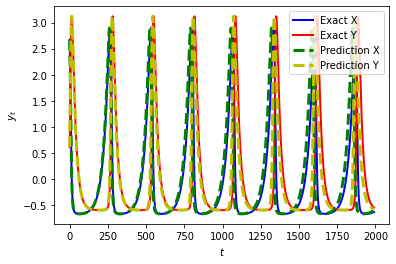

In [12]:
plt.figure(1)
plt.plot(dataset[lags:, 0], 'b-', linewidth = 2, label = "Exact X")
plt.plot(dataset[lags:, 1], 'r-', linewidth = 2, label = "Exact Y")
plt.plot(pred[:, 0], 'g--', linewidth = 3, label = "Prediction X")
plt.plot(pred[:, 1], "y--", linewidth = 3, label = "Prediction Y")
#plt.plot(X.shape[1] * np.ones((2,1)), np.linspace(-1.75, 1.75, 2), 'k--', linewidth=2)
plt.axis('tight')
plt.xlabel('$t$')
plt.ylabel('$y_t$')
plt.legend(loc = 'upper right')